# Suicide detection

Contents

1. Data analysis\
1.1. Basic statistics for unprocessed data\
1.2. Word frequency statistics for unprocessed data
2. Preprocessing\
2.1. Text sanitization\
2.2. Text tokenization\
2.3. Text normalization\
2.4. Stop word removal\
2.5. Word statistics for cleaned data\
2.6. Bigrams for processed text\
2.7. Finding linguistic patterns\
2.8. Drop rows with less than 4 tokens\
2.9. Train-test split\
2.10. Text vectorization (baseline)
3. Evaluation methodology\
3.1. Cost matrix and custom scoring function\
3.2. Performance metrics
4. Baseline model\
4.1. Multinomial naive bayes\
4.2. Unigrams and bigrams\
4.3. Extra features (VADER sentiment, Flesch ease, Entropy Scaling)\
4.4. Smaller vocabulary
5. Random forest classifier\
5.1. Smaller vocabulary\
5.2. Larger vocabulary
6. TPOT
7. LSTM (Keras and Tensorflow)\
7.1. Word embeddings\
7.2. GloVe embeddings
8. Transformers\
8.1. DistilBert
9. Evaluate on unseen data\
9.1. Baseline model (MNB) evaluation\
9.2. LSTM + GloVe embeddings evaluation\
9.3. Transformers: DistilBert evaluation

![image.png](cover_img.png)

# 1. Data analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import itertools
import pickle # To save GloVe embeddings index

import wordninja # Used to split words such as iamteapot -> [i, am, teapot]
from wordcloud import WordCloud
from scipy.stats import entropy # For feature engineering
import textstat # To get readability scores

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist
from nltk.collocations import BigramCollocationFinder
from nltk.metrics import BigramAssocMeasures
from nltk.sentiment.vader import SentimentIntensityAnalyzer

nltk.download('punkt') 
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('vader_lexicon') # Sentiment analyzer data

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import FunctionTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score

# Use tpot genetic algorithm to try to classify with custom score
from tpot import TPOTClassifier

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, GlobalMaxPooling1D
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer as KerasTokenizer
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Transformers
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification, DistilBertConfig
from ast import literal_eval
from tqdm import tqdm # To print bert training progress

[nltk_data] Downloading package punkt to /Users/tashvit/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/tashvit/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/tashvit/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/tashvit/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
/Users/tashvit/Documents/GitHub/python_fun/.venv/lib/python3.12/site-packages/tpot/builtins/__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")


In [2]:
# Creating pandas DataFrame
suicide_detect_data = pd.read_csv("Suicide_Detection.csv", index_col=0)

# Checking the first 5 rows of the DataFrame
suicide_detect_data.head()

,text,class
2,Ex Wife Threatening SuicideRecently I left my ...,suicide
3,Am I weird I don't get affected by compliments...,non-suicide
4,Finally 2020 is almost over... So I can never ...,non-suicide
8,i need helpjust help me im crying so hard,suicide
9,"I’m so lostHello, my name is Adam (16) and I’v...",suicide


In [3]:
# Reset index so that the suicide data index begins from 0
suicide_detect_data.reset_index(drop=True, inplace=True)

suicide_detect_data.head(3)

,text,class
0,Ex Wife Threatening SuicideRecently I left my ...,suicide
1,Am I weird I don't get affected by compliments...,non-suicide
2,Finally 2020 is almost over... So I can never ...,non-suicide


In [4]:
# Printing out the first 3 rows from the dataset to see their text in full

# List containing the first 3 posts
list(suicide_detect_data['text'].head(3))

["Ex Wife Threatening SuicideRecently I left my wife for good because she has cheated on me twice and lied to me so much that I have decided to refuse to go back to her. As of a few days ago, she began threatening suicide. I have tirelessly spent these paat few days talking her out of it and she keeps hesitating because she wants to believe I'll come back. I know a lot of people will threaten this in order to get their way, but what happens if she really does? What do I do and how am I supposed to handle her death on my hands? I still love my wife but I cannot deal with getting cheated on again and constantly feeling insecure. I'm worried today may be the day she does it and I hope so much it doesn't happen.",
 "Am I weird I don't get affected by compliments if it's coming from someone I know irl but I feel really good when internet strangers do it",
 'Finally 2020 is almost over... So I can never hear "2020 has been a bad year" ever again. I swear to fucking God it\'s so annoying']

Looking at the texts, it can be seen that the posts contain stopwords, digits, URLs and punctuation that should be removed during pre-processing.

## 1.1. Basic statistics for unprocessed data

In [5]:
# Dataset size

# Printing number of rows, columns
suicide_detect_data.shape

(232074, 2)

In [6]:
# Data types

suicide_detect_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232074 entries, 0 to 232073
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    232074 non-null  object
 1   class   232074 non-null  object
dtypes: object(2)
memory usage: 3.5+ MB


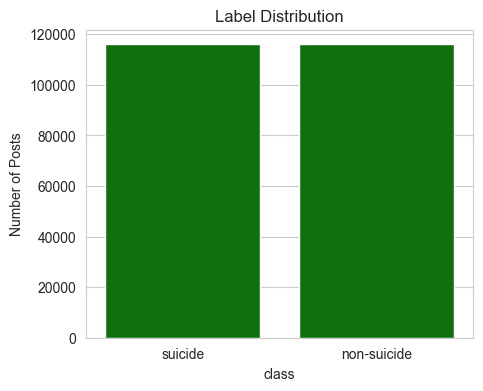

In [7]:
# Class distribution - finding the distribution of the ‘suicide’ and ‘nonsuicide’ labels in the dataset

# Create a bar plot to see label distribution
plt.figure(figsize=(5, 4))
sns.set_style("whitegrid")
sns.countplot(data=suicide_detect_data, x='class', color='green')
plt.title('Label Distribution')
plt.ylabel('Number of Posts')
plt.show()

In [8]:
# Post length -> average number of words in a post

# Create new dataframe to look at statistics of raw data
suicide_stats_data = suicide_detect_data.copy()

# Create new column for tokens
suicide_stats_data['basic_tokens'] = suicide_stats_data['text'].apply(word_tokenize)

# Count the words obtained in previous step and save in new column
suicide_stats_data['word_count'] = suicide_stats_data['basic_tokens'].apply(len)

# Calculate the average post length in terms of words
total_words = suicide_stats_data['word_count'].sum()
average_length = total_words / 232074

# Getting the average length of a post
print(f'Average post length: {average_length} words')

Average post length: 154.65517895154133 words


In [9]:
# Check head of dataframe
suicide_stats_data.head(3)

,text,class,basic_tokens,word_count
0,Ex Wife Threatening SuicideRecently I left my ...,suicide,"[Ex, Wife, Threatening, SuicideRecently, I, le...",156
1,Am I weird I don't get affected by compliments...,non-suicide,"[Am, I, weird, I, do, n't, get, affected, by, ...",29
2,Finally 2020 is almost over... So I can never ...,non-suicide,"[Finally, 2020, is, almost, over, ..., So, I, ...",31


In [10]:
# Post length -> length of longest post

longest_post = suicide_stats_data[suicide_stats_data['word_count'] == suicide_stats_data['word_count'].max()]
longest_post

,text,class,basic_tokens,word_count
105470,"r/teenagers Snoo girl ASCII art, hope you like...",non-suicide,"[r/teenagers, Snoo, girl, ASCII, art, ,, hope,...",23373


It can be seen that the longest post has 23373 words.

Printing out the longest post,

In [11]:
longest_post['text'].values

array(["r/teenagers Snoo girl ASCII art, hope you like it!     ********************************************************************************************************************************************************\n    ********************************************************************************************************************************************************\n    ***********************************************************************#################****************************************************************\n    *****************************************************************###########################************************************************************\n    *************************************************************#################################**********************************************************\n    ***********************************************************#####################################***************************************************

It can be seen that the longest post is an ASCII art piece.

This data point is an outlier and can be removed during pre-processing.

In [12]:
# Checking shorter posts

# Get the posts with word_count = 3
print('Posts with 3 words:')
print(suicide_stats_data[suicide_stats_data['word_count'] == 3]['basic_tokens'].head())
print('\n')

# Get the posts with word_count = 2
print('Posts with 2 words:')
print(suicide_stats_data[suicide_stats_data['word_count'] == 2]['basic_tokens'].head())
print('\n')

# Get the posts with word_count = 1
print('Posts with 1 word:')
print(suicide_stats_data[suicide_stats_data['word_count'] == 1]['basic_tokens'].head())

Posts with 3 words:
1768          [Just, OD'dBye, .]
3147     [Final, strawDoing, it]
7864           [Snoo, bak, Epic]
9549       [HelloWho, is, awake]
12193        [.help, help, help]
Name: basic_tokens, dtype: object


Posts with 2 words:
168      [lmaolmabsjdbbsjxbwnxhhdjsshdcmwbdjjf, jrhdsnd...
664                                         [adopt, mepls]
4894     [Heeeeeeeeeeelllllllllllllllllooooooooooooooo,...
9909     [Aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa...
10749    [Lalalalalalalalalalalalalalalalalalalalalalal...
Name: basic_tokens, dtype: object


Posts with 1 word:
7343                                                [okok]
19503    [AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...
19635    [whiskeyhotelyankeemikeechowhiskeyhotelyankeem...
20619                                    [Help07943179686]
38097                                           [helphelp]
Name: basic_tokens, dtype: object


It can be seen that a lot of the 1 and 2 worded posts don't make sense and can be removed during the data pre-processing stage.

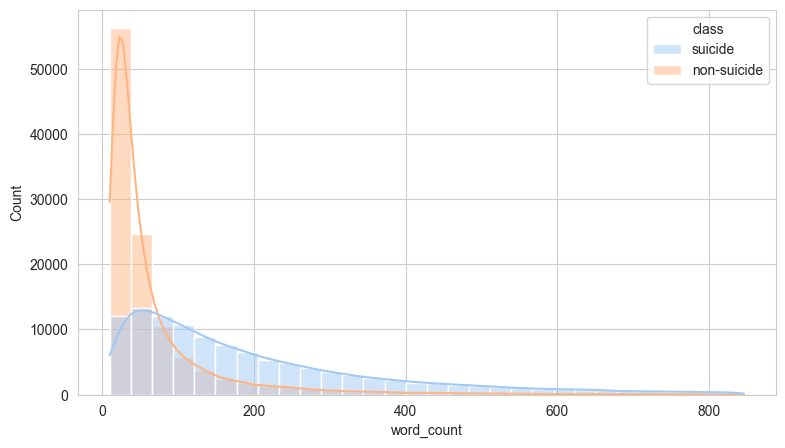

In [13]:
# Histogram to show the distribution of post lengths

# Filtering outliers
q_low = suicide_stats_data['word_count'].quantile(0.02)
q_high = suicide_stats_data['word_count'].quantile(0.98)
df_filtered = suicide_stats_data[(suicide_stats_data['word_count'] < q_high) & (suicide_stats_data['word_count'] > q_low)]

# Draw the plot
plt.figure(figsize=(9, 5))
sns.set_style("whitegrid")
sns.histplot(data=df_filtered, x='word_count', bins=30, hue='class', kde=True, palette='pastel')
plt.show()

The histogram shows the post length distributon of the dataset.

Given that the shortest valid post is about 3 words and the longest is around 800 words (after removing outliers) with an average of 154 words (calculated above), it seems like most of the texts are of moderate length.

Checking post readability,

In [14]:
# Post readability -> Flesch reading ease

# Calculating flesch readability score for every post
suicide_stats_data['flesch_scores'] = suicide_stats_data['text'].apply(textstat.flesch_reading_ease)

# Printing readibility of first 5 posts
suicide_stats_data['flesch_scores'].head()

0     76.15
1     60.99
2     88.02
3    104.64
4     68.50
Name: flesch_scores, dtype: float64

In [15]:
# Post readability -> average post readability

# Average value of the 'flesch_scores' column
suicide_stats_data['flesch_scores'].mean()

np.float64(74.06867063953739)

The average post readability is 74%. This means that the average post in this dataset is fairly easy to read.

## 1.2. Word frequency statistics for unprocessed data

Computing the word frequency statistics for the raw data can provide a better understanding of what steps are needed for pre-processing.

Get all the words from all the posts into a single list to find unique words, common words, bigrams, lexical diversity.

In [16]:
# Obtaining all the words from all the posts into a single list
all_words = list(itertools.chain.from_iterable(suicide_stats_data['basic_tokens']))

# Creating set to contain unique words across all the posts
unique_words = set(all_words)

# Printing number of unique words
print(f'Number of unique words: {len(unique_words)} words')

Number of unique words: 282190 words


Print 100 of the unique words

In [17]:
print(list(unique_words)[:100])

['parents.Hi', 'sleepaway', 'digets', 'words.Well', 'cannibal', 'Rivotril', 'siblings.i', 'looker', 'leftMe', '̠̜̺͎̗̋͋̿̏̏̕̚͘', 'virus😎😎😎😎', 'figure/shape', 'HE', 'First/LastFirst', '4552', 'beethoven', 'ThanksThanks', 'trily', 'serán', 'guysss', 'DaysIm', 'ved=2ahUKEwil9aXEzc3tAhWIMd8KHa\\_9CZEQ9QF6BAgQEAE', 'hair-pulled', 'Deutschland', 'acuse', 'impactful', 'itok', 'yrs', 'terminally', 'soonit', 'undiscoverable', '-ab', '/x', 'dang-', 'ᒷᒲ', 'lowes', 'hotlineWhen', 'days.That', 'professor', 'Illusions', "'think", 'yahtzee', 'mira', '⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢻⣿⣿⣿⢈⣤⣴⡿⠿⠿⠿⢿⣿⣿⣷⣤⣤⣄⠀⢀⠀⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢀⣠⣶⣿⣿⣿⣿⡿⠷⠿⠿⠿⠠⣠⠤⠀⠀⠘⢻⣿⣿⣿⣿⠀⠀⠀⠀⠀⠀⠀⠀⠀⢠⣼⣿⣿⣿⣿⣿⣿⣿⣿', '💔Imma', 'peines', 'rapids', 'bullied/depressed', 'tú', '29.12.2018', 'caregiving', 'readyIm', '30,00', 'BOMBS', 'abso-fucking-lutely', 'fricks', 'scratcher', 'nerve-pain', 'overdoseSeriously', 'revenue', 'Clutzy', 'UsI', '^any', 'Convenience', 'boohooing', 'france', 'COACH', 'rehashes', 'if.The', 'titling', 'medacine', '400LB', '̸̛̣̩̠͇̘͖̱̖̩̅̋͂͋̕͟͠͞', 'gl

Cleaning the data during the pre-processing stage will bring down the number of unique words due to actions such as text normalization, punctuation removal, stop word removal etc.

Finding the most common words in the unprocessed data for each class,

In [18]:
# Obtaining all the words from all the posts in the 2 classes into 2 lists

words_suicide_class = suicide_stats_data[suicide_stats_data['class'] == 'suicide']['basic_tokens']
words_nonsuicide_class = suicide_stats_data[suicide_stats_data['class'] == 'non-suicide']['basic_tokens']

all_words_suicide_class = list(itertools.chain.from_iterable(words_suicide_class))
all_words_nonsuicide_class = list(itertools.chain.from_iterable(words_nonsuicide_class))

# Compute the frequency distribution using nltk FreqDist method
## For suicide class
freq_dist_suicide_class = FreqDist(all_words_suicide_class)

## For non-suicide class
freq_dist_nonsuicide_class = FreqDist(all_words_nonsuicide_class)

# Print common words
print('25 most common words in suicide class:')
print(freq_dist_suicide_class.most_common(25))
print('\n')
print('25 most common words in non-suicide class:')
print(freq_dist_nonsuicide_class.most_common(25))

25 most common words in suicide class:
[('I', 1649278), ('.', 1373013), ('to', 842429), (',', 826205), ('and', 677312), ('the', 478256), ('a', 454663), ('my', 453631), ('of', 344258), ('me', 337964), ('it', 327255), ('that', 280033), ("n't", 279436), ('’', 245210), ('in', 241903), ('do', 239234), ('have', 221971), ('for', 211550), ('is', 210848), ('just', 195256), ("'m", 192511), ('but', 192212), ('i', 188841), ('was', 176600), ('this', 166579)]


25 most common words in non-suicide class:
[('I', 301857), ('.', 270409), (',', 212687), ('to', 183996), ('and', 177942), ('the', 155070), ('a', 152120), ('it', 102168), ('’', 98048), ('my', 97159), ('of', 86456), ('you', 81806), ('?', 81048), ('me', 73422), ('that', 72799), ('is', 68164), ('in', 66427), ('i', 61115), ('for', 57156), ('but', 49959), ('!', 49536), ('just', 48801), ('do', 48568), ('have', 48174), ('this', 46630)]


Since the data is unprocessed, the most common words in both classes are stop words and punctuation.

Identifying the 10 most common bi-grams in the unprocessed posts for each class,

In [19]:
# Use a BigramCollocationFinder object to get most common bi-grams for each class
bigram_extractor_suicide_class = BigramCollocationFinder.from_documents(words_suicide_class)
bigram_extractor_nonsuicide_class = BigramCollocationFinder.from_documents(words_nonsuicide_class)

# Get bigrams for both classes
top_10_bigrams_suicide_class = bigram_extractor_suicide_class.nbest(BigramAssocMeasures.likelihood_ratio, 10)
top_10_bigrams_nonsuicide_class = bigram_extractor_nonsuicide_class.nbest(BigramAssocMeasures.likelihood_ratio, 10)

# Print bigrams
print("Most common bi-grams in suicide class:")
for bigram in top_10_bigrams_suicide_class:
    print(bigram)
print("\n")
print("Most common bi-grams in nonsuicide class:")
for bigram in top_10_bigrams_nonsuicide_class:
    print(bigram)

Most common bi-grams in suicide class:
('.', 'I')
('I', "'m")
('’', 't')
('do', "n't")
('’', 'm')
('ca', "n't")
('want', 'to')
('’', 's')
('don', '’')
(',', 'but')


Most common bi-grams in nonsuicide class:
('\u200d', '\u200d')
('filler', 'filler')
('’', 't')
('*', '*')
('’', 's')
('’', 'm')
('I', "'m")
('Filler', 'Filler')
('ㅤ', 'ㅤ')
('\u200c', '\u200c')


It can be seen that the bi-grams obtained at this stage are not very useful for extracting meaningful conclusions, as the data has not yet been preprocessed.

Calculating lexical diversity of the unprocessed posts,

In [20]:
# Function to calculate lexical diversity of a post given its tokens
def lexical_diversity(tokens):
    if len(tokens) == 0:  # Avoid division by zero
        return 0
    return len(set(tokens)) / len(tokens)

# Creating new column to contain the lexical diversity of every post
suicide_stats_data['lexical_diversity'] = suicide_stats_data['basic_tokens'].apply(lexical_diversity)

# Print the first 5 data rows
suicide_stats_data['lexical_diversity'].head()

0    0.641026
1    0.827586
2    0.935484
3    1.000000
4    0.461832
Name: lexical_diversity, dtype: float64

In [21]:
# Calculate the mean lexical diversity for all the posts 
# by calculating the average value of the 'lexical_diversity' column
suicide_stats_data['lexical_diversity'].mean()

np.float64(0.7028852981359316)

The posts have a lexical diversity score of 0.70, which indicates a moderate level of vocabulary variety within the text

This means that 70% of the words are unique, while the remaining 30% are repetitions.

# 2. Preprocessing

In [22]:
# Check for missing values

suicide_detect_data.isna().sum()

text     0
class    0
dtype: int64

In [23]:
# Finding duplicate rows

suicide_detect_data[suicide_detect_data.duplicated()]

,text,class


## 2.1. Text sanitization

This step involves removing numbers, emojis, hashtags, URLs and other unnecessary characters from the text data.

In [24]:
# Function to handle text sanitizing
def sanitize_text(text: str) -> str:
    """
    Remove text that does not have any meaningful use for machine learning 
    Wordninja library is used to split apart words that are stuck together
    
    :param text: original text
    :return: cleaned text
    """

    # Regular expression to remove URLs
    text = re.sub(r'http\S+|www\S+', ' ', text)
    # Regular expression to remove digits
    text = re.sub(r'\d+', ' ', text)
    # Remove any unwanted extra white spaces
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Code to split badly stuck together words using wordninja library
    # Split text on empty space
    simple_words = text.split(' ')
    # Look for and split words that are stuck together using wordninja
    split_words_list = (wordninja.split(word) for word in simple_words)
    
    # Join back the words of the split text
    text = " ".join(itertools.chain.from_iterable(split_words_list))
    # Convert text to lowercase
    text = text.lower()
    
    return text

In [25]:
# Creating a new dataframe to preserve the original
suicide_detect_ml = suicide_detect_data.copy()

# Apply the text cleaning function to the text data from the posts 
## and store the result in a new column
suicide_detect_ml['cleaned_text'] = suicide_detect_ml['text'].apply(sanitize_text)

# Print a few rows to check cleaned text
suicide_detect_ml.head()

,text,class,cleaned_text
0,Ex Wife Threatening SuicideRecently I left my ...,suicide,ex wife threatening suicide recently i left my...
1,Am I weird I don't get affected by compliments...,non-suicide,am i weird i don't get affected by compliments...
2,Finally 2020 is almost over... So I can never ...,non-suicide,finally is almost over so i can never hear has...
3,i need helpjust help me im crying so hard,suicide,i need help just help me im crying so hard
4,"I’m so lostHello, my name is Adam (16) and I’v...",suicide,i m so lost hello my name is adam and i ve bee...


## 2.2. Text tokenization

In [26]:
# Create column for tokens
suicide_detect_ml['tokens'] = suicide_detect_ml['cleaned_text'].apply(word_tokenize)

# Print a few rows to check tokens
suicide_detect_ml.iloc[130:135]

,text,class,cleaned_text,tokens
130,Feeling alone with my suicidal feelingsMy suic...,suicide,feeling alone with my suicidal feelings my sui...,"[feeling, alone, with, my, suicidal, feelings,..."
131,Not depressed or sad but getting more comforta...,suicide,not depressed or sad but getting more comforta...,"[not, depressed, or, sad, but, getting, more, ..."
132,.Fuckin a man. Why is it there isn’t a single ...,suicide,fuckin a man why is it there isn t a single fu...,"[fuckin, a, man, why, is, it, there, isn, t, a..."
133,It doesn’t get better.I tried to kill myself t...,suicide,it doesn t get better i tried to kill myself t...,"[it, doesn, t, get, better, i, tried, to, kill..."
134,Posting every day until I get a girlfriend day...,non-suicide,posting every day until i get a girlfriend day...,"[posting, every, day, until, i, get, a, girlfr..."


## 2.3. Text normalization

The text data has been normalized using lemmatization rather than stemming. This is because the dataset has been compiled through subreddit posts that will likely contain emotional textual expressions and nuances. Unlike stemming, lemmatization will produce valid words and preserve the meanings of the words. The valid word forms that result through lemmatization is more interpretable, and could also be useful for future research analyses.

In [27]:
# Create a wordnetlemmatizer instance
word_net_lemmatizer = WordNetLemmatizer()

# Function to lemmatize tokens
def lemmatize(tokens):
    """
    Lemmatize given word token list and return a lemmatized word list
    
    :param tokens: original tokens
    :return: lemmatized tokens
    """
    return [word_net_lemmatizer.lemmatize(token) for token in tokens]

In [28]:
# Create new column to store lemmatized text
suicide_detect_ml['lemmatized'] = suicide_detect_ml['tokens'].apply(lemmatize)

# Print some rows of original text column and lemmatized column side by side
suicide_detect_ml[['text', 'lemmatized']].iloc[20:25]

,text,lemmatized
20,"I am ending my life today, goodbye everyone.I ...","[i, am, ending, my, life, today, goodbye, ever..."
21,Me: I know I have a really toxic house and I d...,"[me, i, know, i, have, a, really, toxic, house..."
22,Trapped inside a voidDear whoever cares enough...,"[trapped, inside, a, void, dear, whoever, care..."
23,Posting Galadriel’s opening monologue every da...,"[posting, galadriel, s, opening, monologue, ev..."
24,"Do you sleep with Socks On,and how do you feel...","[do, you, sleep, with, sock, on, and, how, do,..."


## 2.4. Stop word removal

Removing the words that offer little lexical content by using NLTK's in-built list of stop words.

Repeating words such as 'filler filler' below to have no contextual meaning. (see image). Therefore these will be removed.

![filler_img](filler.png "picture")

In [29]:
# Get the list of English stopwords
stop_words = set(stopwords.words('english'))
# Remove HTML escape leftovers
stop_words.add('amp')
stop_words.add('nbsp')

# Function to remove repeated words
def repeated_words_filter(tokens):
    """
    Removes repeated words
    :param tokens: original tokens
    :return: filtered tokens
    """
    result = []
    previous = ''
    for token in tokens:
        if token == previous:
            continue
        result.append(token)
        previous = token
    return result

# Function to remove stop words and words that have less than 2 letters
def remove_stop_words_and_filter(tokens):
    """
    Removes - stop words, words with length less than 2, words with "'" and repeated words
       takes a list of words and return a filtered word list
    :param tokens: original tokens
    :return: filtered tokens
    """
    return repeated_words_filter(word for word in tokens if (len(word) > 2 and word not in stop_words and "'" not in word))


In [30]:
# Apply function to remove stop words and filter repeated words
suicide_detect_ml['filtered_words'] = suicide_detect_ml['lemmatized'].apply(remove_stop_words_and_filter)

# Print some original posts and cleaned posts side by side
suicide_detect_ml[['text', 'filtered_words']].iloc[170:175]

,text,filtered_words
170,i have no reason to live anymoremy online frie...,"[reason, live, anymore, online, friend, talk, ..."
171,Planning to kill myself at 29hey guys\n\nlet m...,"[planning, kill, hey, guy, let, start, brief, ..."
172,I’m fucking I’m fucking I’m fucking LET ME DRI...,"[fucking, let, drink, blood, yum, let, drink, ..."
173,I missed my own warning signs.I somehow didn't...,"[missed, warning, sign, somehow, notice, even,..."
174,It's my 19th birthday today... I don't know if...,"[birthday, today, know, happy, officially, yea..."


## 2.5. Word statistics for cleaned data

In [31]:
# Word statistics -> Unique words in cleaned data

# Creating set to contain unique words across all the posts from cleaned data
all_words = itertools.chain.from_iterable(suicide_detect_ml['filtered_words'])
unique_words = set(all_words)

# Printing number of unique words 
print(f'Number of unique words in cleaned data: {len(unique_words)} words')

Number of unique words in cleaned data: 46430 words


In [32]:
# Word statistics -> Common words in cleaned data

# Function to get word frequency distributions
def get_word_frequencies(dataframe, column):
    """
    Create a frequency distribution.
    :param dataframe: data frame
    :param column: column name that contained cleaned tokens
    :return: frequency distribution of words
    """
    # Obtaining all the words from all the posts into a single list
    all_words = list(itertools.chain.from_iterable(dataframe[column]))
    # Compute the frequency distribution using nltk FreqDist method
    freq_dist = FreqDist(all_words)
    return freq_dist

# Extracting 'suicide' class data into a new dataframe
suicide_data = suicide_detect_ml[suicide_detect_ml['class'] == 'suicide']

# Extracting 'non-suicide' class data into a new dataframe
non_suicide_data = suicide_detect_ml[suicide_detect_ml['class'] == 'non-suicide']

print('Most common words in suicide class:')
print(get_word_frequencies(suicide_data, 'filtered_words').most_common(25))
print('\n')
print('Most common words in non-suicide class:')
print(get_word_frequencies(non_suicide_data, 'filtered_words').most_common(25))

Most common words in suicide class:
[('want', 134760), ('like', 132777), ('feel', 120009), ('life', 119755), ('know', 110583), ('get', 93368), ('time', 85768), ('would', 77628), ('even', 77206), ('year', 74556), ('one', 73536), ('people', 73527), ('friend', 70968), ('thing', 66726), ('really', 63868), ('think', 60410), ('day', 57900), ('going', 57354), ('never', 56838), ('make', 51113), ('much', 50840), ('help', 50249), ('could', 45809), ('anymore', 44491), ('thought', 44184)]


Most common words in non-suicide class:
[('like', 51561), ('get', 27127), ('know', 25911), ('want', 22670), ('people', 22315), ('day', 22029), ('friend', 21870), ('one', 21546), ('time', 19552), ('really', 17978), ('feel', 16635), ('would', 16268), ('got', 15675), ('think', 15427), ('make', 14998), ('school', 14989), ('guy', 14655), ('thing', 14558), ('girl', 14509), ('year', 14150), ('even', 13924), ('say', 13214), ('good', 12928), ('need', 12001), ('post', 11405)]


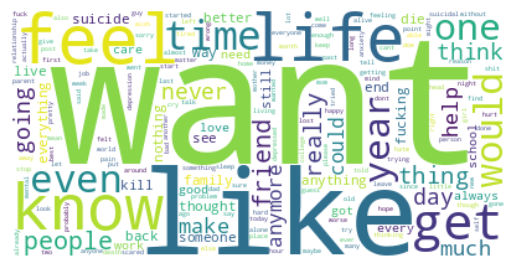

In [33]:
# Function to create word cloud visualizations for both classes

def wordcloud(dataframe, column):
    """
    Create a word cloud from given data frame and tokens list column.
    
    :param dataframe: data frame
    :param column: column name that contained cleaned tokens
    :return: None
    """
    words_dist = get_word_frequencies(dataframe, column)
    wc = WordCloud(background_color="white", max_words=1000)
    wc.generate_from_frequencies(words_dist)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()


# Word cloud for 'suicide' class

# Extracting 'suicide' class data into a new dataframe
suicide_data = suicide_detect_ml[suicide_detect_ml['class'] == 'suicide']
wordcloud(suicide_data, 'filtered_words')

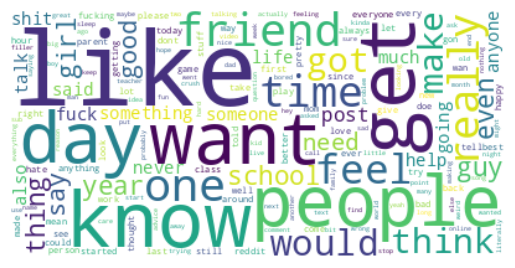

In [34]:
# Word cloud for 'non-suicide' class

# Extracting 'non-suicide' class data into a new dataframe
non_suicide_data = suicide_detect_ml[suicide_detect_ml['class'] == 'non-suicide']
wordcloud(non_suicide_data, 'filtered_words')

## 2.6. Bigrams for processed text

Getting the bigrams in the cleaned data to look for key themes and topics in each class.

In [35]:
# Use a BigramCollocationFinder object to get most common bi-grams for each class
bigram_extractor_suicide_class = BigramCollocationFinder.from_documents(suicide_data['filtered_words'])
bigram_extractor_nonsuicide_class = BigramCollocationFinder.from_documents(non_suicide_data['filtered_words'])

# Get bigrams for both classes
top_30_bigrams_suicide_class = bigram_extractor_suicide_class.nbest(BigramAssocMeasures.likelihood_ratio, 30)
top_30_bigrams_nonsuicide_class = bigram_extractor_nonsuicide_class.nbest(BigramAssocMeasures.likelihood_ratio, 30)

# Print bigrams for each class
print("Most common bi-grams in suicide class:")
print(top_30_bigrams_suicide_class)
print("\n")
print("Most common bi-grams in nonsuicide class:")
print(top_30_bigrams_nonsuicide_class)

Most common bi-grams in suicide class:
[('feel', 'like'), ('want', 'die'), ('year', 'old'), ('high', 'school'), ('every', 'day'), ('get', 'better'), ('mental', 'health'), ('suicidal', 'thought'), ('year', 'ago'), ('best', 'friend'), ('even', 'though'), ('commit', 'suicide'), ('panic', 'attack'), ('wish', 'could'), ('month', 'ago'), ('self', 'harm'), ('every', 'single'), ('video', 'game'), ('sub', 'reddit'), ('piece', 'shit'), ('last', 'year'), ('mental', 'illness'), ('need', 'help'), ('anyone', 'else'), ('first', 'time'), ('dont', 'know'), ('last', 'night'), ('long', 'time'), ('pretty', 'much'), ('felt', 'like')]


Most common bi-grams in nonsuicide class:
[('jake', 'paul'), ('feel', 'like'), ('fuck', 'jake'), ('paul', 'fuck'), ('tik', 'tok'), ('year', 'old'), ('sub', 'reddit'), ('anyone', 'else'), ('insta', 'gram'), ('even', 'though'), ('best', 'friend'), ('high', 'school'), ('discord', 'server'), ('doe', 'anyone'), ('mental', 'health'), ('need', 'help'), ('never', 'gon'), ('anyone', 

## 2.7. Finding linguistic patterns

The code below extracts bigrams of the 'suicide' and 'non suicide' text, and removes common bigrams from the 'suicide' text.

In [36]:
suicide_bigrams = bigram_extractor_suicide_class.nbest(BigramAssocMeasures.likelihood_ratio, 500)
nonsuicide_bigrams = bigram_extractor_nonsuicide_class.nbest(BigramAssocMeasures.likelihood_ratio, 500)
linguistic_patterns = set(suicide_bigrams) - set(nonsuicide_bigrams)

print(sorted(linguistic_patterns))

[('absolutely', 'nothing'), ('across', 'country'), ('almost', 'year'), ('anti', 'depressant'), ('anxiety', 'attack'), ('anxiety', 'depression'), ('anxiety', 'disorder'), ('anymore', 'want'), ('anything', 'anymore'), ('anytime', 'soon'), ('around', 'neck'), ('ask', 'help'), ('attempted', 'suicide'), ('attention', 'seeking'), ('back', 'forth'), ('back', 'home'), ('bank', 'account'), ('ben', 'dry'), ('better', 'without'), ('beyond', 'repair'), ('bipolar', 'disorder'), ('blow', 'brain'), ('borderline', 'personality'), ('bottle', 'pill'), ('brain', 'damage'), ('breaking', 'point'), ('burden', 'everyone'), ('buy', 'gun'), ('call', 'police'), ('came', 'home'), ('cant', 'even'), ('car', 'accident'), ('carbon', 'monoxide'), ('care', 'anymore'), ('chronic', 'pain'), ('clinical', 'depression'), ('closest', 'friend'), ('come', 'home'), ('coming', 'back'), ('committed', 'suicide'), ('committing', 'suicide'), ('community', 'college'), ('completely', 'alone'), ('computer', 'science'), ('considering',

It can be seen that all the bigrams here fit the theme of depression and suicidal ideation.

The bigrams are what one would expect to see in a study of texts concerning suicide, though interestingly ('computer', 'science') also appears on the list.

The bigrams confirm the existence of phrases and words that can serve as linguistic indicators in depressive content.

In [37]:
suicide_detect_ml.head()

,text,class,cleaned_text,tokens,lemmatized,filtered_words
0,Ex Wife Threatening SuicideRecently I left my ...,suicide,ex wife threatening suicide recently i left my...,"[ex, wife, threatening, suicide, recently, i, ...","[ex, wife, threatening, suicide, recently, i, ...","[wife, threatening, suicide, recently, left, w..."
1,Am I weird I don't get affected by compliments...,non-suicide,am i weird i don't get affected by compliments...,"[am, i, weird, i, do, n't, get, affected, by, ...","[am, i, weird, i, do, n't, get, affected, by, ...","[weird, get, affected, compliment, coming, som..."
2,Finally 2020 is almost over... So I can never ...,non-suicide,finally is almost over so i can never hear has...,"[finally, is, almost, over, so, i, can, never,...","[finally, is, almost, over, so, i, can, never,...","[finally, almost, never, hear, bad, year, ever..."
3,i need helpjust help me im crying so hard,suicide,i need help just help me im crying so hard,"[i, need, help, just, help, me, im, crying, so...","[i, need, help, just, help, me, im, cry, so, h...","[need, help, cry, hard]"
4,"I’m so lostHello, my name is Adam (16) and I’v...",suicide,i m so lost hello my name is adam and i ve bee...,"[i, m, so, lost, hello, my, name, is, adam, an...","[i, m, so, lost, hello, my, name, is, adam, an...","[lost, hello, name, adam, struggling, year, af..."


## 2.8. Drop rows with less than 4 tokens

In [38]:
# Checking posts with less than 4 tokens in the 'filtered_words' column

suicide_detect_ml['word_count'] = suicide_detect_ml['filtered_words'].apply(len)

suicide_detect_ml[suicide_detect_ml['word_count'] < 4].head()

,text,class,cleaned_text,tokens,lemmatized,filtered_words,word_count
58,OwThe past is unforgiving,suicide,ow the past is unforgiving,"[ow, the, past, is, unforgiving]","[ow, the, past, is, unforgiving]","[past, unforgiving]",2
135,Don’t you dare listen to music ‍ ‍ ‍ ‍ ‍ ‍ ‍ ‍...,non-suicide,don t you dare listen to music,"[don, t, you, dare, listen, to, music]","[don, t, you, dare, listen, to, music]","[dare, listen, music]",3
139,IN THE BOOK OF HEAVY METAL ‎,non-suicide,in the book of heavy metal,"[in, the, book, of, heavy, metal]","[in, the, book, of, heavy, metal]","[book, heavy, metal]",3
178,How to be happy!: a tutorial 1.,non-suicide,how to be happy a tutorial,"[how, to, be, happy, a, tutorial]","[how, to, be, happy, a, tutorial]","[happy, tutorial]",2
207,my chimney is on fire help Idk what to do,non-suicide,my chimney is on fire help i dk what to do,"[my, chimney, is, on, fire, help, i, dk, what,...","[my, chimney, is, on, fire, help, i, dk, what,...","[chimney, fire, help]",3


In [39]:
# Save a copy
suicide_detect_ml_saved = suicide_detect_ml.copy()

# Rows containing less than 4 tokens don't appear to be useful data points and can be removed
suicide_detect_ml = suicide_detect_ml[suicide_detect_ml['word_count'] > 3]

## 2.9. Train-test split

A holdout set will be kept aside for evaluating the performance of the model at the end. 

The holdout/testing set will not be seen by the model during model training and validating. 

It will be used at the end to see how well the model can generalize to unseen data.

In [40]:
# Convert class to a number, where suicide == 1 and non-suicide == 0
suicide_detect_ml['target_class'] = suicide_detect_ml['class'].apply(lambda x: 1 if x == 'suicide' else 0)

In [41]:
# Save to CSV
#suicide_detect_ml.to_csv('clean_data.csv', index=False)

In [42]:
# First take out the sanitized data in a way we can split it to training and test split
data_tokens_all = suicide_detect_ml['filtered_words'].copy()
data_class_all = suicide_detect_ml['class'].copy()

print("token arrays shape =",data_tokens_all.shape)
print("class number shape=", data_class_all.shape)

token arrays shape = (227307,)
class number shape= (227307,)


In [43]:
# Split between seen and unseen data 
## (seen data will be used for training and validation, while 
## unseen data can be used to test the final models)
X_seen_data, X_unseen_data, y_seen_data, y_unseen_data = train_test_split(data_tokens_all, 
                                                                          data_class_all, 
                                                                          test_size=0.33, 
                                                                          random_state=4567)

CLASSES = ['non-suicide', 'suicide']

X_seen_data.shape, y_seen_data.shape, X_unseen_data.shape, y_unseen_data.shape

((152295,), (152295,), (75012,), (75012,))

# 3. Evaluation methodology

## 3.1. Cost matrix and custom scoring function

Misclassifying posts, especially false negatives (where a suicidal message is classified as 'non-suicide') can lead to harmful outcomes.

A cost matrix will be used to assign costs to each type of classification error.

Because false negatives are heavily undesirable for this project a higher cost will be assigned for false negatives than for other types of errors.

In [44]:
# Creating cost matrix
COST_MATRIX = np.array([
    [0, 1],  # Cost for non suicide
    [10, 0]   # Cost for suicide (Classifying suicide as non-suicide is considered very costly)
])

# Custom scoring function that can use the cost matrix
def custom_scoring(y_val, y_pred):
    """
    Create a custom score for suicide data where we consider 
      false negative (suicide as a non-suicide) to be very negative
    :param y_val: actual target
    :param y_pred: predicted target
    :return: score -- larger the better
    """
    cm = confusion_matrix(y_val, y_pred)
    cost_of_model = np.multiply(cm, COST_MATRIX).sum()
    return -(cost_of_model / len(y_pred))

## 3.2. Performance metrics

1. Recall (Sensitivity):

- Minimizes false negatives.
- Measures the proportion of true positive predictions among all actual positives.

2. Accuracy:

- Can provide a good indication of model performance, since the 2 classes are balanced.
- Measures the proportion of total correct predictions (both positive and negative)

3. Precision:

- Calculates the proportion of true positive predictions among all positive predictions.
- Precision can be a good metric as there is also a cost associated with false positives.

4. F1-score

- F1-score is a metric for finding the balance between precision and recall (the Harmonic mean of Precision and Recall)

A separate test set wil be used to evaluate the results, and cross-validation will be performed for better results.

In [50]:
# Function to analyze model performance

def analyze_model(model, X_val, y_val, model_name=""):
    """
    Analyze the model based on validation data
    
    :param X_val: validation features
    :param y_val: validation target
    :return: None
    """
    y_pred = model.predict(X_val)
    cm = confusion_matrix(y_val, y_pred)
    cost_of_model = np.multiply(cm, COST_MATRIX).sum()
    print("================" * 4)
    print(f"{model_name} metrics")
    print("================" * 4)
    print(f"accuracy score          =", round(accuracy_score(y_val, y_pred) * 100, 3), "%")
    print(f"cost of model           =", round(cost_of_model, 3))
    print(f"F1 score  - suicide     =", round(f1_score(y_val, y_pred, pos_label='suicide') * 100, 3), "%")
    print(f"F1 score  - non-suicide =", round(f1_score(y_val, y_pred, pos_label='non-suicide') * 100, 3), "%")
    print(f"recall    - suicide     =", round(recall_score(y_val, y_pred, pos_label='suicide') * 100, 3), "%")
    print(f"recall    - non-suicide =", round(recall_score(y_val, y_pred, pos_label='non-suicide') * 100, 3), "%")
    print(f"precision - suicide     =", round(precision_score(y_val, y_pred, average='binary', pos_label='suicide') * 100, 3), "%")
    print(f"precision - non-suicide =", round(precision_score(y_val, y_pred, average='binary', pos_label='non-suicide') * 100, 3), "%")
    print("================" * 4)
    # Define the labels and titles for the confusion matrix
    title = f'Confusion matrix for {model_name}'
    # Create a heatmap of the confusion matrix
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=CLASSES, yticklabels=CLASSES)
    
    # Set the axis labels and title
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    
    # Add legends for the heatmap
    bottom, top = plt.ylim()
    plt.ylim(bottom + 0.5, top - 0.5)
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.show()

# 4. Baseline model

## 4.1. Multinomial naive bayes

**Reasons to select Multinomial Naive Bayes as a baseline classifier:**

1. Naive Bayes models assume that the features are independent given the class. This will simplify computation and still provide a decent baseline performance.

2. This project is a text classification task and Multinomial Naive Bayes is particularly capable of handling text data well. The distribution of the word tokens (features) is assumed to be multinomial.

3. Naive Bayes classifiers can handle large datasets and many features. This dataset has a large number of features because every unique token is considered to be a feature.

4. It is a probabilistic model that can provide the posterior probabilities of the classifications that it makes. Understanding how confident the model is in its predictions can be helpful.

In [53]:
# TfidfVectorizer vectorization will be used to create vocabularies

# Limiting vocabulary size to reduce computational time
MAX_VOCABULARY = 5000

# Function to pass into the TfidfVectorizer,
#   this is used because the sentences have already been tokenised
def do_nothing(x): 
    return x

# Creating a function to perform baseline vectorization
def baseline_vectorize(documents):
    """
    Create a vectorizer based on given training documents
      this is used for the baseline model
    
    :param dataframe: array of word-tokens
    :return: vectorizer
    """
    # Disable the tokenizer and preprocessor, as it was done in previous pre-processing steps
    vectorizer = TfidfVectorizer(tokenizer=do_nothing, preprocessor=do_nothing, lowercase=False, max_features=MAX_VOCABULARY)
    # Tokenize and build vocabulary
    vectorizer.fit(documents.copy())
    # Summarize
    print(sorted(vectorizer.vocabulary_)[:50]) # Only show 50 words
    print("vocabulary size =", len(vectorizer.vocabulary_))
    return vectorizer

# Building vocabulary from 'X_seen_data'
baseline_vectorizer = baseline_vectorize(X_seen_data)
X = baseline_vectorizer.transform(X_seen_data)
y = y_seen_data

/Users/tashvit/Documents/GitHub/python_fun/.venv/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


['aaa', 'aaaa', 'aaaaaa', 'abandon', 'abandoned', 'abandoning', 'abandonment', 'ability', 'able', 'abortion', 'abroad', 'absence', 'absent', 'absolute', 'absolutely', 'absurd', 'abuse', 'abused', 'abuser', 'abusing', 'abusive', 'abyss', 'academic', 'academically', 'acc', 'accent', 'accept', 'acceptable', 'acceptance', 'accepted', 'accepting', 'access', 'accident', 'accidental', 'accidentally', 'accomplish', 'accomplished', 'accomplishment', 'according', 'account', 'accurate', 'accused', 'ace', 'ache', 'achieve', 'achieved', 'achievement', 'achieving', 'aching', 'acid']
vocabulary size = 5000


In [54]:
# Check the sizes

X.shape, y.shape

((152295, 5000), (152295,))

In [55]:
# Using train_test_split function again to split the seen data into training and validation sets
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.2, random_state=6789)

# Check sizes
X_train.shape, X_validation.shape, y_train.shape, y_validation.shape

((121836, 5000), (30459, 5000), (121836,), (30459,))

In [56]:
# Creating baseline model

def baseline_model(X_train_data, y_train_data):
    """
    Create baseline model
    
    :param X_train_data: traininig features
    :param y_train_data: target
    :return: model that is fit with given training data
    """
    mnb = MultinomialNB()
    mnb.fit(X_train_data.copy(), y_train_data.copy())
    return mnb

Baseline model - Multinomial Naive Bayes metrics
accuracy score          = 89.724 %
cost of model           = 10933
F1 score  - suicide     = 90.342 %
F1 score  - non-suicide = 89.021 %
recall    - suicide     = 94.409 %
recall    - non-suicide = 84.865 %
precision - suicide     = 86.612 %
precision - non-suicide = 93.604 %


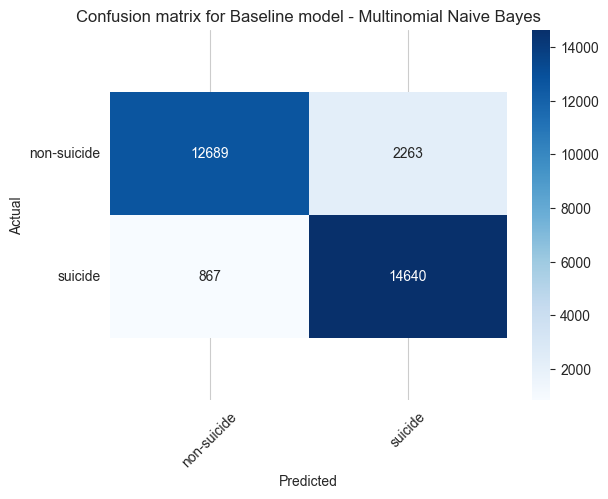

In [57]:
# Creating instance of baseline model and analyzing its performance

mnb_model = baseline_model(X_train, y_train)
analyze_model(mnb_model, X_validation, y_validation, "Baseline model - Multinomial Naive Bayes")

## 4.2. Unigrams and bigrams

Using unigrams and bigrams together can result in better performance because they each capture different types of information that can be useful for the model.

In [51]:
def a1_unigrams_bigrams_vectorize(documents):
    """
    Create a vectorizer based on given training documents
      this uses bigrams in addition to unigrams
    
    :param dataframe: array of word-tokens
    :return: vectorizer
    """
    # Disable tokenizer and preprocessor as it was done in previous pre-processing steps
    vectorizer = TfidfVectorizer(tokenizer=do_nothing, preprocessor=do_nothing,
                                 lowercase=False, max_features=MAX_VOCABULARY, ngram_range=(1,2))
    # Tokenize and build vocabulary
    vectorizer.fit(documents.copy())
    # Summarize
    print(sorted(vectorizer.vocabulary_)[:50]) # Only show 50 words
    print("vocabulary size =", len(vectorizer.vocabulary_))
    return vectorizer

# Model training is the same
a1_unigrams_bigrams_multi_nb = baseline_model

/Users/tashvit/Documents/GitHub/python_fun/.venv/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


['aaaaaa', 'abandon', 'abandoned', 'ability', 'able', 'able find', 'able get', 'able make', 'able see', 'abortion', 'abroad', 'absolute', 'absolutely', 'absolutely nothing', 'abuse', 'abused', 'abuser', 'abusing', 'abusive', 'academic', 'accept', 'accepted', 'accepting', 'access', 'accident', 'accidentally', 'accomplish', 'accomplished', 'according', 'account', 'accused', 'ache', 'achieve', 'achieved', 'acknowledge', 'acne', 'acquaintance', 'across', 'act', 'act like', 'acted', 'acting', 'acting like', 'action', 'active', 'actively', 'activity', 'actual', 'actually', 'actually care']
vocabulary size = 5000
Attempt 1 - unigrams and bigrams with multinomial naive bayes metrics
accuracy score          = 90.036 %
cost of model           = 11486
F1 score  - suicide     = 90.566 %
F1 score  - non-suicide = 89.442 %
recall    - suicide     = 93.945 %
recall    - non-suicide = 85.982 %
precision - suicide     = 87.422 %
precision - non-suicide = 93.193 %


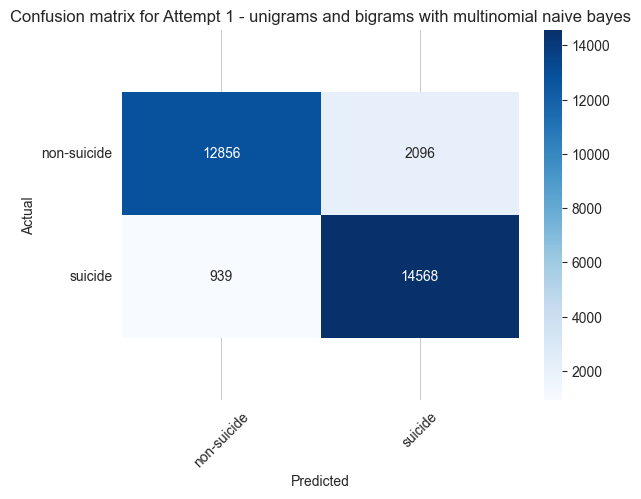

In [52]:
# Using the new vectorizer function to create vocubulary and re-train the model

# Create new vocabulary
a1_vectorizer = a1_unigrams_bigrams_vectorize(X_seen_data)

X = a1_vectorizer.transform(X_seen_data)
y = y_seen_data

# Split the seen data into training and testing
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.2, random_state=6789)

# Train the model
a1_model = a1_unigrams_bigrams_multi_nb(X_train, y_train)

# Validation
analyze_model(a1_model, X_validation, y_validation, "Attempt 1 - unigrams and bigrams with multinomial naive bayes")

This attempt has only slightly different scores for accuracy, precision and recall than the first attempt. The F1 score is slightly higher than the baseline performance, indicating a slightly better balance between recall and precision.

## 4.3. Extra features (VADER sentiment, Flesch ease, Entropy Scaling)

- VADER Sentiment is useful for extracting sentiment from text and it may serve as a useful feature for this classification task
- Flesch Ease measures text complexity and could potentially find a specific average reading score in the 'suicide' class that is different from the 'non-suicide' class
- Entropy Scaling measures randomness and this value could maybe be useful for differentiating among the weights (importance) of  different words or features

The VADER sentiment assigns a score of negative, neutral or positive to each post.

The Flesch ease score calculates readability for each post, and the entropy score calculates the approximate entropy for each post.

A copy of the baseline model is trained with these additional features included.

/Users/tashvit/Documents/GitHub/python_fun/.venv/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


['aaaaaa', 'abandon', 'abandoned', 'ability', 'able', 'able find', 'able get', 'able make', 'able see', 'abortion', 'abroad', 'absolute', 'absolutely', 'absolutely nothing', 'abuse', 'abused', 'abuser', 'abusing', 'abusive', 'academic', 'accept', 'accepted', 'accepting', 'access', 'accident', 'accidentally', 'accomplish', 'accomplished', 'according', 'account', 'accused', 'ache', 'achieve', 'achieved', 'acknowledge', 'acne', 'acquaintance', 'across', 'act', 'act like', 'acted', 'acting', 'acting like', 'action', 'active', 'actively', 'activity', 'actual', 'actually', 'actually care']
vocabulary size = 5000
Attempt 2 - bigrams/unigrams + features metrics
accuracy score          = 90.958 %
cost of model           = 13653
F1 score  - suicide     = 91.214 %
F1 score  - non-suicide = 90.687 %
recall    - suicide     = 92.191 %
recall    - non-suicide = 89.68 %
precision - suicide     = 90.258 %
precision - non-suicide = 91.717 %


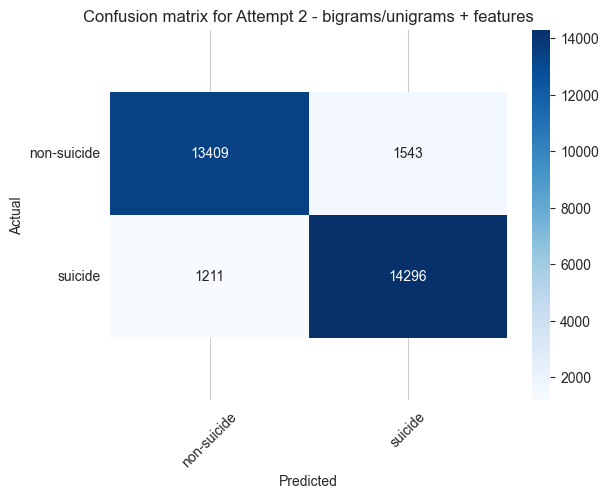

In [53]:
# SentimentIntensityAnalyzer object for vader sentiment
sentiment = SentimentIntensityAnalyzer()

# Reference for entropy scaling - https://stats.stackexchange.com/questions/95261/why-am-i-getting-information-entropy-greater-than-1
def entropy_scaled(tokens):
    """
    Get approximate entropy (scaled)

    :param tokens: tokens of a single row
    :return: entropy
    """
    sentence = " ".join(tokens)
    byte_array = list(sentence.encode('utf-8'))
    counts = np.bincount(byte_array)
    probabilities = counts[counts > 0] / len(byte_array)
    return [entropy(probabilities) / np.log(256)]

def scale_value(val, max_val):
    """
    Scale a value between [0 - max] to be [0 - 1] (out of bounds values are clipped)
    :param val: value to scale
    :param max_val: maximum value
    :return: scaled value
    """
    return min(max_val, max(0.0, val)) / max_val

def flesch_ease(tokens):
    """
    Readability score of the given sentence (only tokens are considered)
      so it is joined to a sentence using " ".join(tokens)
    :param tokens: tokens of a single row
    :returns: readability score
    """
    sentence = " ".join(tokens)
    return [scale_value(textstat.flesch_reading_ease(sentence), 100.0)]

def vader(tokens):
    """
    Get vader sentiment's negative, neutral and positive scores
    :param tokens: tokens of a single row
    :returns: vader sentiment [neg, neu, pos]
    """
    sentence = " ".join(tokens)
    scores = sentiment.polarity_scores(sentence)
    return [scores['neg'], scores['neu'], scores['pos']]

class TextMetricsTransformer(BaseEstimator, TransformerMixin):
    """
    Feature extracting transformer
    """
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return [entropy_scaled(data) + flesch_ease(data) + vader(data) for data in X]

# Get union of features [vectorized tokens + entropy + flesch_ease + vader]
a2_vectorizer = a1_unigrams_bigrams_vectorize
a2_features = FeatureUnion([('tfidf_vec', a2_vectorizer(X_seen_data)), ('text_metrics', TextMetricsTransformer())])

a2_model_train = baseline_model # model training is the same

X = a2_features.transform(X_seen_data)
y = y_seen_data

X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.2, random_state=6789)

a2_model = a2_model_train(X_train, y_train)

analyze_model(a2_model, X_validation, y_validation, "Attempt 2 - bigrams/unigrams + features")

This model appears to have a slightly improved trade-off between recall and precision. It also has the highest accuracy score of any model yet.

Next, a smaller vocabulary can be used to find out if this has an effect on the evaluation metrics.

## 4.4. Use a smaller vocabulary

For this attempt, a smaller vocabulary will be used to see if it would provide a better result.

**Rationale:** 

- a smaller vocabulary may help the model avoid overfitting to rare words in the training set that do not appear in general
- a model trained on a large vocabuary may find it harder to deal with unknown words than a model that uses a smaller vocabulary
- a smaller vocabulary can sometimes lead to improved model performance

In [54]:
SMALLER_VOCAB_SIZE = 500
def a3_smaller_vocab_vectorize(documents):
    """
    Create a smaller vocabulary model
    :param tokens: tokens of a single row
    :returns: readability score
    """
    # Disable tokenizer and preprocessor as it was done in previous pre-processing steps
    vectorizer = TfidfVectorizer(tokenizer=do_nothing, preprocessor=do_nothing,
                                 lowercase=False, max_features=SMALLER_VOCAB_SIZE, max_df=0.9, min_df=0.05,
                                 ngram_range=(1,3))
    # Tokenize and build vocabulary
    vectorizer.fit(documents.copy())
    # Summarize
    print(sorted(vectorizer.vocabulary_)[:50]) # Only show 50 words
    print("vocabulary size =", len(vectorizer.vocabulary_))
    return vectorizer

/Users/tashvit/Documents/GitHub/python_fun/.venv/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


['able', 'actually', 'ago', 'almost', 'alone', 'already', 'also', 'always', 'another', 'anymore', 'anyone', 'anything', 'around', 'away', 'back', 'bad', 'best', 'better', 'care', 'come', 'could', 'cry', 'day', 'death', 'depressed', 'depression', 'die', 'doe', 'done', 'dont', 'else', 'end', 'enough', 'even', 'ever', 'every', 'everyone', 'everything', 'family', 'feel', 'feel like', 'feeling', 'felt', 'find', 'first', 'friend', 'fuck', 'fucking', 'get', 'getting']
vocabulary size = 176
Attempt 3 - smaller vocabulary metrics
accuracy score          = 85.886 %
cost of model           = 22056
F1 score  - suicide     = 86.295 %
F1 score  - non-suicide = 85.452 %
recall    - suicide     = 87.277 %
recall    - non-suicide = 84.444 %
precision - suicide     = 85.334 %
precision - non-suicide = 86.485 %


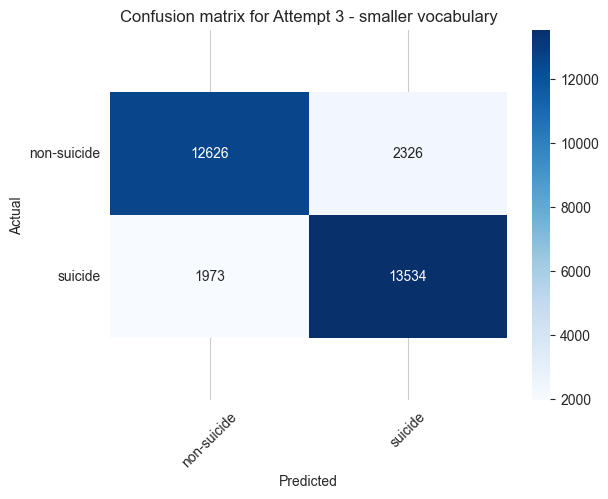

In [55]:
# Create a feature union with small vectorizer + extra features
a3_features = FeatureUnion([('tfidf_vec', a3_smaller_vocab_vectorize(X_seen_data)), ('text_metrics', TextMetricsTransformer())])
a3_model_train = baseline_model # model training is the same
X = a3_features.transform(X_seen_data)
y = y_seen_data

# Split seen data into training and testing
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.2, random_state=6789)

a3_model = a3_model_train(X_train, y_train)
analyze_model(a3_model, X_validation, y_validation, "Attempt 3 - smaller vocabulary")

The third attempt has produced worse results than the baseline performance.

# 5. Random forest classifier

## 5.1. Smaller vocabulary

Using a random forest classifier with a smaller vocabulary may help prevent the model from overfitting to the data.

/Users/tashvit/Documents/GitHub/python_fun/.venv/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


['able', 'actually', 'ago', 'almost', 'alone', 'already', 'also', 'always', 'another', 'anymore', 'anyone', 'anything', 'around', 'away', 'back', 'bad', 'best', 'better', 'care', 'come', 'could', 'cry', 'day', 'death', 'depressed', 'depression', 'die', 'doe', 'done', 'dont', 'else', 'end', 'enough', 'even', 'ever', 'every', 'everyone', 'everything', 'family', 'feel', 'feel like', 'feeling', 'felt', 'find', 'first', 'friend', 'fuck', 'fucking', 'get', 'getting']
vocabulary size = 176


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   45.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   48.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.3s finished


Attempt 4 - smaller vocabulary + random forest metrics
accuracy score          = 88.493 %
cost of model           = 20407
F1 score  - suicide     = 88.606 %
F1 score  - non-suicide = 88.377 %
recall    - suicide     = 87.889 %
recall    - non-suicide = 89.119 %
precision - suicide     = 89.335 %
precision - non-suicide = 87.647 %


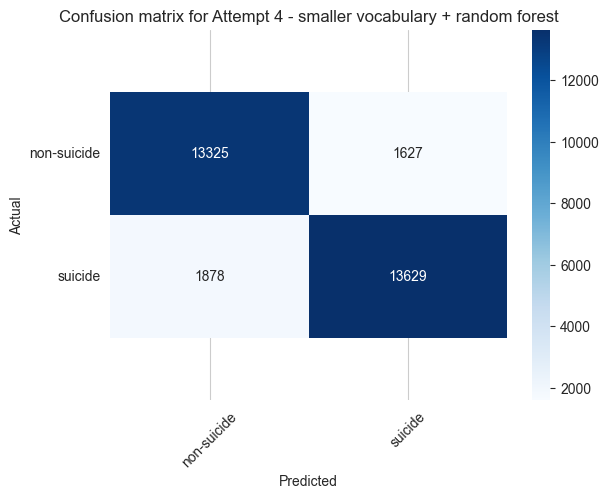

In [56]:
def random_forest_model(X_train_data, y_train_data):
    """
    Create a random forest classifer and train it
    :param X_train_data: features
    :param y_train_data: target 
    :returns: trained model
    """
    rfc = RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=14785, verbose=1)
    rfc.fit(X_train_data.copy(), y_train_data.copy())
    return rfc

a4_model_train = random_forest_model

a4_vectorizer = a3_smaller_vocab_vectorize
a4_features = FeatureUnion([('tfidf_vec', a4_vectorizer(X_seen_data)), ('text_metrics', TextMetricsTransformer())])

X = a4_features.transform(X_seen_data)
y = y_seen_data

# Split seen data into training and testing
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.2, random_state=6789)

# Train the model
a4_model = a4_model_train(X_train, y_train)

# Analyze and get results
analyze_model(a4_model, X_validation, y_validation, "Attempt 4 - smaller vocabulary + random forest")

This attempt has not produced significantly different results from the baseline performance.

## 5.2. Larger vocabulary

A random forest classifier can sometimes be better at preventing overfitting than multinomial naive bayes when a larger vocabulary is being used.

Using the original vocabulary,

/Users/tashvit/Documents/GitHub/python_fun/.venv/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


['aaaaaa', 'abandon', 'abandoned', 'ability', 'able', 'able find', 'able get', 'able make', 'able see', 'abortion', 'abroad', 'absolute', 'absolutely', 'absolutely nothing', 'abuse', 'abused', 'abuser', 'abusing', 'abusive', 'academic', 'accept', 'accepted', 'accepting', 'access', 'accident', 'accidentally', 'accomplish', 'accomplished', 'according', 'account', 'accused', 'ache', 'achieve', 'achieved', 'acknowledge', 'acne', 'acquaintance', 'across', 'act', 'act like', 'acted', 'acting', 'acting like', 'action', 'active', 'actively', 'activity', 'actual', 'actually', 'actually care']
vocabulary size = 5000


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   47.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   50.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.4s finished


Attempt 5 - larger vocabulary + random forest metrics
accuracy score          = 90.325 %
cost of model           = 15448
F1 score  - suicide     = 90.549 %
F1 score  - non-suicide = 90.089 %
recall    - suicide     = 91.043 %
recall    - non-suicide = 89.58 %
precision - suicide     = 90.061 %
precision - non-suicide = 90.604 %


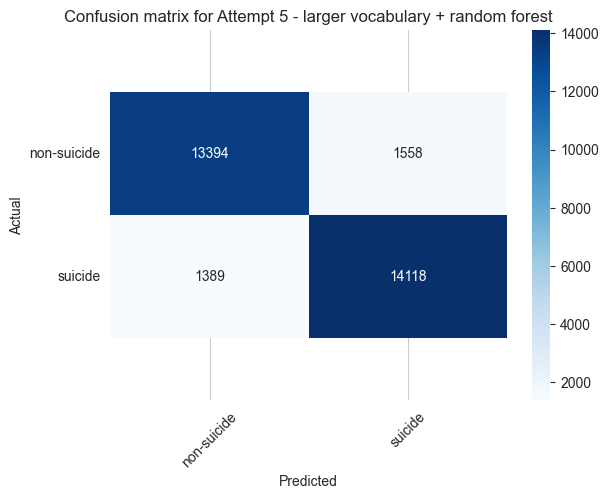

In [57]:
a5_model_train = random_forest_model

a5_vectorizer = a1_unigrams_bigrams_vectorize
a5_features = FeatureUnion([('tfidf_vec', a5_vectorizer(X_seen_data)), ('text_metrics', TextMetricsTransformer())])

X = a5_features.transform(X_seen_data)
y = y_seen_data

X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.2, random_state=6789)

# Training model
a5_model = a5_model_train(X_train, y_train)

# Get results
analyze_model(a5_model, X_validation, y_validation, "Attempt 5 - larger vocabulary + random forest")

This model performs around the same as the baseline model.

# 6. TPOT

A custom scoring function for TPOT that uses a genetic algorithm will be used to improve the scores. This attempt uses the combined collection of features and the smaller vocabulary from attempt 3.

In [58]:
a6_vectorizer = a3_smaller_vocab_vectorize
a6_features = FeatureUnion([('tfidf_vec', a6_vectorizer(X_seen_data)), ('text_metrics', TextMetricsTransformer())])

/Users/tashvit/Documents/GitHub/python_fun/.venv/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


['able', 'actually', 'ago', 'almost', 'alone', 'already', 'also', 'always', 'another', 'anymore', 'anyone', 'anything', 'around', 'away', 'back', 'bad', 'best', 'better', 'care', 'come', 'could', 'cry', 'day', 'death', 'depressed', 'depression', 'die', 'doe', 'done', 'dont', 'else', 'end', 'enough', 'even', 'ever', 'every', 'everyone', 'everything', 'family', 'feel', 'feel like', 'feeling', 'felt', 'find', 'first', 'friend', 'fuck', 'fucking', 'get', 'getting']
vocabulary size = 176


In [59]:
# Extract features from seen data
X = a6_features.transform(X_seen_data)
y = y_seen_data

# Split data into training and test data
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.2, random_state=6789)

In [60]:
# Custom scorer using sklearn 'make_scorer' function 
## that uses the previous 'custom_scoring' function 
## to impose a high penalty for misclassifying 'suicide' cases as 'non-suicide'

# Using make_scorer function from sklearn to create a usable object for TPOT
custom_scorer = make_scorer(custom_scoring, greater_is_better=True)

tc = TPOTClassifier(generations=3, population_size=4, cv=5,
                                   random_state=4245, verbosity=2,
                                   config_dict = 'TPOT sparse', n_jobs=10,
                                   use_dask=True, warm_start=False,
                                   scoring=custom_scorer)

tc.fit(X_train.copy(), y_train.copy())

Optimization Progress:   0%|          | 0/16 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -0.6569650211106207

Generation 2 - Current best internal CV score: -0.6567187881331276

Generation 3 - Current best internal CV score: -0.6562016933227319

Best pipeline: LogisticRegression(input_matrix, C=5.0, dual=False, penalty=l2)


TPOTClassifier(config_dict='TPOT sparse', generations=3, n_jobs=10,
               population_size=4, random_state=4245,
               scoring=make_scorer(custom_scoring, response_method='predict'),
               use_dask=True, verbosity=2)

Attempt 6 - TPOT metrics
accuracy score          = 88.834 %
cost of model           = 20942
F1 score  - suicide     = 88.855 %
F1 score  - non-suicide = 88.813 %
recall    - suicide     = 87.431 %
recall    - non-suicide = 90.289 %
precision - suicide     = 90.326 %
precision - non-suicide = 87.384 %


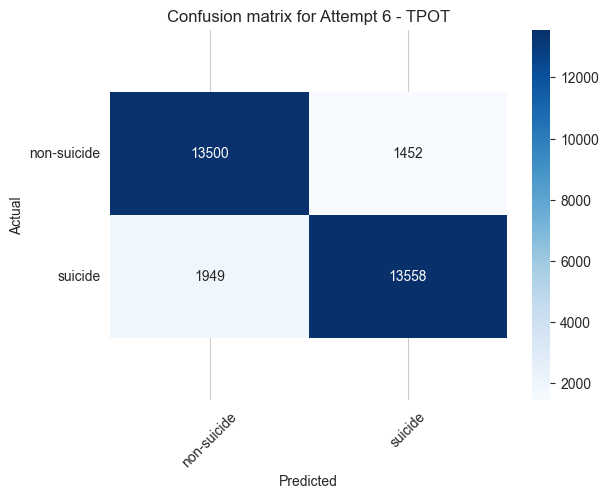

In [61]:
# Get results
analyze_model(tc, X_validation, y_validation, "Attempt 6 - TPOT")

In [62]:
# Printing current tpot pipeline created by the TPOT genetic algorithm

tc.export("current_tpot_pipeline.py")
with open("current_tpot_pipeline.py", "r") as h:
    print(h.read())

import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# NOTE: Make sure that the outcome column is labeled 'target' in the data file
tpot_data = pd.read_csv('PATH/TO/DATA/FILE', sep='COLUMN_SEPARATOR', dtype=np.float64)
features = tpot_data.drop('target', axis=1)
training_features, testing_features, training_target, testing_target = \
            train_test_split(features, tpot_data['target'], random_state=4245)

# Average CV score on the training set was: -0.6562016933227319
exported_pipeline = LogisticRegression(C=5.0, dual=False, penalty="l2")
# Fix random state in exported estimator
if hasattr(exported_pipeline, 'random_state'):
    setattr(exported_pipeline, 'random_state', 4245)

exported_pipeline.fit(training_features, training_target)
results = exported_pipeline.predict(testing_features)



It can be seen that the tpot model has used a LogisticRegression to get the results for attempt 6.

# 7. LSTM (Keras and Tensorflow)

## 7.1. Word embeddings

In [61]:
# Check the first 5 rows of the seen data
X_seen_data.head()

204152    [waking, disappointed, live, see, another, day...
62283     [happened, chat, room, bring, back, fun, could...
27916                           [hah, depression, brr, rrr]
7827      [mma, ing, post, viral, mma, change, school, p...
198302    [feeling, giving, hello, name, alexander, expl...
Name: filtered_words, dtype: object

In [62]:
y_seen_data.head()

204152        suicide
62283     non-suicide
27916     non-suicide
7827      non-suicide
198302        suicide
Name: class, dtype: object

In [63]:
# Split seen data into training and testing
X_train, X_validation, y_train, y_validation = train_test_split(X_seen_data, y_seen_data, test_size=0.2, random_state=6789)

# Map y data string labels to numeric to be used in training
y_train_numeric = y_train.apply(lambda x: {'suicide': 1, 'non-suicide': 0}[x])
y_train_np = np.array(y_train_numeric, dtype=np.float32)

y_validation_numeric = y_validation.apply(lambda x: {'suicide': 1, 'non-suicide': 0}[x])
y_validation_np = np.array(y_validation_numeric, dtype=np.float32)

In [58]:
# Create sequence feature transform function 
## that allows X data to be used for LSTM training

vocab_size = 500
max_length = 60
embedding_dim = 25

def create_feature_transform(texts):
    """
    Convert text to a sequence that can be used for LSTM training
    :param texts: tokens list
    :returns: input sequence padded to max_length
    """
    tokenizer = KerasTokenizer(num_words=vocab_size, oov_token='<oov>')
    tokenizer.fit_on_texts(texts)
    
    # Reference: https://www.scaler.com/topics/python/python-closure/
    def transform(to_transform_text):
        sequences = tokenizer.texts_to_sequences(to_transform_text)
        # Using lstm pad_sequences function to pad the end of the sequence with shorter sequences
        # Longer sequences will be truncated
        return pad_sequences(sequences, maxlen=max_length, padding='post')
    return transform, tokenizer


# Create a feature transforming function
to_features, tokenizer = create_feature_transform(X_train)

# Convert text to features using the to_features
train_features = to_features(X_train)
val_features = to_features(X_validation)

In [59]:
# Create function that can use X transformed features to train a LSTM model

def train_lstm_model(x_features, y_target):
    """
    Train an LSTM model
    :param x_features: features
    :param y_target: target 
    :returns: trained model
    """
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length))
    model.add(LSTM(units=100))
    model.add(Dense(units=1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.fit(x_features, y_target, epochs=30, batch_size=128)
    return model

In [62]:
# Train model
lstm_model = train_lstm_model(train_features, y_train_np)

# Save the model to a file
lstm_model.save('lstm_model_1.keras')

Epoch 1/30


/Users/tashvit/Documents/GitHub/python_fun/.venv/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


952/952 ━━━━━━━━━━━━━━━━━━━━ 45s 47ms/step - accuracy: 0.8362 - loss: 0.3692
Epoch 2/30
952/952 ━━━━━━━━━━━━━━━━━━━━ 45s 47ms/step - accuracy: 0.9067 - loss: 0.2472
Epoch 3/30
952/952 ━━━━━━━━━━━━━━━━━━━━ 44s 47ms/step - accuracy: 0.9083 - loss: 0.2421
Epoch 4/30
952/952 ━━━━━━━━━━━━━━━━━━━━ 44s 47ms/step - accuracy: 0.9086 - loss: 0.2385
Epoch 5/30
952/952 ━━━━━━━━━━━━━━━━━━━━ 45s 47ms/step - accuracy: 0.9087 - loss: 0.2345
Epoch 6/30
952/952 ━━━━━━━━━━━━━━━━━━━━ 44s 46ms/step - accuracy: 0.9104 - loss: 0.2325
Epoch 7/30
952/952 ━━━━━━━━━━━━━━━━━━━━ 43s 46ms/step - accuracy: 0.9110 - loss: 0.2308
Epoch 8/30
952/952 ━━━━━━━━━━━━━━━━━━━━ 43s 45ms/step - accuracy: 0.9101 - loss: 0.2297
Epoch 9/30
952/952 ━━━━━━━━━━━━━━━━━━━━ 44s 47ms/step - accuracy: 0.9120 - loss: 0.2269
Epoch 10/30
952/952 ━━━━━━━━━━━━━━━━━━━━ 43s 45ms/step - accuracy: 0.9103 - loss: 0.2323
Epoch 11/30
952/952 ━━━━━━━━━━━━━━━━━━━━ 44s 46ms/step - accuracy: 0.9096 - loss: 0.2277
Epoch 12/30
952/952 ━━━━━━━━━━━━━━━━━━━━ 

In [67]:
# Function to get model results

# A copy of the analyze function has been modified so it suits LSTM output

def analyze_lstm_model(model, X_val, y_val, model_name="LSTM"):
    """
    Analyze LSTM model model based on validation data
    
    :param X_val: validation features
    :param y_val: validation target
    :return: None
    """
    y_pred = model.predict(X_val)
    # convert to a binary classification
    y_pred = [('suicide' if p[0] > 0.5 else 'non-suicide') for p in y_pred]
    cm = confusion_matrix(y_val, y_pred)
    cost_of_model = np.multiply(cm, COST_MATRIX).sum()
    print("================" * 4)
    print(f"{model_name} metrics")
    print("================" * 4)
    print(f"accuracy score          =", round(accuracy_score(y_val, y_pred) * 100, 3), "%")
    print(f"cost of model           =", round(cost_of_model, 3))
    print(f"F1 score  - suicide     =", round(f1_score(y_val, y_pred, pos_label='suicide') * 100, 3), "%")
    print(f"F1 score  - non-suicide =", round(f1_score(y_val, y_pred, pos_label='non-suicide') * 100, 3), "%")
    print(f"recall    - suicide     =", round(recall_score(y_val, y_pred, pos_label='suicide') * 100, 3), "%")
    print(f"recall    - non-suicide =", round(recall_score(y_val, y_pred, pos_label='non-suicide') * 100, 3), "%")
    print(f"precision - suicide     =", round(precision_score(y_val, y_pred, average='binary', pos_label='suicide') * 100, 3), "%")
    print(f"precision - non-suicide =", round(precision_score(y_val, y_pred, average='binary', pos_label='non-suicide') * 100, 3), "%")
    print("================" * 4)
    # Define the labels and titles for the confusion matrix
    title = f'Confusion matrix for {model_name}'
    # Create a heatmap of the confusion matrix
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=CLASSES, yticklabels=CLASSES)
    
    # Set the axis labels and title
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    
    # Add legends for the heatmap
    bottom, top = plt.ylim()
    plt.ylim(bottom + 0.5, top - 0.5)
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.show()

In [61]:
# Load the saved model
lstm_model_1 = load_model('lstm_model_1.keras')

952/952 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step
LSTM model with word embedding metrics
accuracy score          = 89.245 %
cost of model           = 19377
F1 score  - suicide     = 89.333 %
F1 score  - non-suicide = 89.154 %
recall    - suicide     = 88.463 %
recall    - non-suicide = 90.055 %
precision - suicide     = 90.22 %
precision - non-suicide = 88.272 %


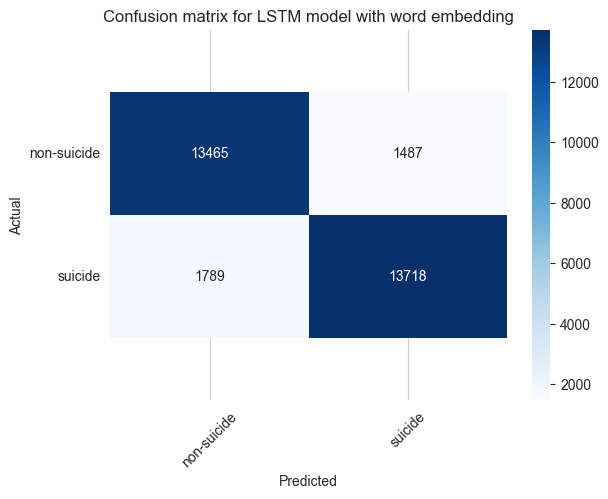

In [62]:
analyze_lstm_model(lstm_model_1, val_features, y_validation, "LSTM model with word embedding")

## 7.2. GloVe embeddings

Download pre-trained GloVe embeddings and load into a dictionary.

In [31]:
# glove.840B.300d.zip - downloaded from https://nlp.stanford.edu/projects/glove/

# Load GloVe embeddings into dictionary
def load_glove_embeddings(file_path, embedding_dim):
    malformed_lines = 0
    all_lines = 0
    embeddings_index = {}
    
    with open(file_path, encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]  # Extract the word
            all_lines += 1
            try:
                # Ensure all values after the word are numeric and match the expected dimension
                vector = np.asarray(values[1:], dtype='float32')
                if len(vector) == embedding_dim:
                    embeddings_index[word] = vector
            except ValueError:
                malformed_lines += 1

    print(f"Loaded {len(embeddings_index)} word vectors.")
    print(f"Malformed lines: {malformed_lines} lines")
    print(f"All lines: {all_lines} lines")
    
    return embeddings_index


glove_file = "glove.840B.300d.txt"  # Path to GloVe file
embedding_dim = 300

# Create embeddings index
embeddings_index = load_glove_embeddings(glove_file, embedding_dim)

# Save embeddings_index to a pickle file
with open("glove.840B.300d_tashvit.pkl", "wb") as f:
    pickle.dump(embeddings_index, f)

Loaded 2195875 word vectors.
Malformed lines: 20 lines
All lines: 2196017 lines


In [59]:
# Load embeddings_index from the pickle file
with open("glove.840B.300d_tashvit.pkl", "rb") as f:
    embeddings_index = pickle.load(f)

print(f"Loaded {len(embeddings_index)} word vectors from pickle.")

Loaded 2195875 word vectors from pickle.


In [64]:
# Create feature transform function that uses GloVe embeddings

vocab_size = 40041 # len(tokenizer.word_index) + 1
max_length = 60 # Padding length
embedding_dim = 300 # Match the GloVe embedding dimensions

def feature_transform_embedding_matrix(texts):
    """
    Convert text to a sequence that can be used for LSTM training
    :param texts: tokens list
    :returns: input sequence padded to max_length
    """
    tokenizer = KerasTokenizer(num_words=vocab_size, oov_token='<oov>')
    tokenizer.fit_on_texts(texts)

    # Dictionary mapping words to their indices
    word_index = tokenizer.word_index

    # Create an embedding matrix using the GloVe embeddings
    embedding_matrix = np.zeros((vocab_size, embedding_dim))  # Initialize with zeros
    for word, i in word_index.items():
        if word == '<oov>':
            continue
        if i < vocab_size:  # Only consider words within the vocab size
            embedding_vector = embeddings_index.get(word[1:-1])  # Lookup GloVe vector
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector  # Assign GloVe vector

    # Reference: https://www.scaler.com/topics/python/python-closure/
    def transform(to_transform_text):
        sequences = tokenizer.texts_to_sequences(to_transform_text)
        # Using lstm pad_sequences function to pad the end of the sequence with shorter sequences
        # Longer sequences will be truncated
        return pad_sequences(sequences, maxlen=max_length, padding='post')
    return transform, tokenizer, embedding_matrix


# Use the feature transforming function
to_glove_features, tokenizer, embedding_matrix = feature_transform_embedding_matrix(X_train)

# Convert text to features using the to_features
train_features = to_glove_features(X_train)
val_features = to_glove_features(X_validation)

In [52]:
# Create function that can use X transformed features to train a LSTM model

def train_glove_lstm(x_features, y_target, val_features, y_validation, embedding_matrix):
    """
    Train an LSTM model with GloVe embeddings
    :param x_features: features
    :param y_target: target
    :returns: trained model
    """    
    model = Sequential()
    
    # Embedding layer with GloVe weights
    model.add(Embedding(input_dim=vocab_size, 
                        output_dim=embedding_dim, 
                        weights=[embedding_matrix],
                        input_length=max_length, 
                        trainable=False))
    
    # LSTM layers
    model.add(LSTM(units=128, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))
    
    # GlobalMaxPooling1D to reduce the sequence to a fixed feature vector
    model.add(GlobalMaxPooling1D())
    
    # Dense layers for classification
    model.add(Dense(units=64, activation='relu'))
    model.add(Dropout(0.5))  # Regularization
    model.add(Dense(units=1, activation='sigmoid'))  # Output layer
    
    # Compile the model
    model.compile(optimizer='adam', 
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])

    # Use an adaptive learning rate scheduler
    lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)
    model.fit(x_features, y_target, epochs=5, batch_size=128, validation_data=(val_features, y_validation), 
              callbacks=[lr_scheduler])
    
    return model

In [53]:
# Train model

glove_lstm_model = train_glove_lstm(train_features, y_train_np, val_features, y_validation_np, embedding_matrix)

# Save the model to a file
glove_lstm_model.save('glove_lstm_model.keras')

Epoch 1/5


/Users/tashvit/Documents/GitHub/python_fun/.venv/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


952/952 ━━━━━━━━━━━━━━━━━━━━ 101s 104ms/step - accuracy: 0.8688 - loss: 0.3154 - val_accuracy: 0.9227 - val_loss: 0.1984 - learning_rate: 0.0010
Epoch 2/5
952/952 ━━━━━━━━━━━━━━━━━━━━ 102s 108ms/step - accuracy: 0.9220 - loss: 0.2044 - val_accuracy: 0.9261 - val_loss: 0.1909 - learning_rate: 0.0010
Epoch 3/5
952/952 ━━━━━━━━━━━━━━━━━━━━ 101s 106ms/step - accuracy: 0.9305 - loss: 0.1838 - val_accuracy: 0.9313 - val_loss: 0.1807 - learning_rate: 0.0010
Epoch 4/5
952/952 ━━━━━━━━━━━━━━━━━━━━ 104s 110ms/step - accuracy: 0.9381 - loss: 0.1674 - val_accuracy: 0.9358 - val_loss: 0.1755 - learning_rate: 0.0010
Epoch 5/5
952/952 ━━━━━━━━━━━━━━━━━━━━ 103s 108ms/step - accuracy: 0.9405 - loss: 0.1591 - val_accuracy: 0.9303 - val_loss: 0.1905 - learning_rate: 0.0010


In [65]:
# Load the saved model
glove_lstm_model = load_model('glove_lstm_model.keras')

952/952 ━━━━━━━━━━━━━━━━━━━━ 17s 17ms/step
LSTM model with GloVe embeddings metrics
accuracy score          = 93.03 %
cost of model           = 7091
F1 score  - suicide     = 93.372 %
F1 score  - non-suicide = 92.65 %
recall    - suicide     = 96.44 %
recall    - non-suicide = 89.493 %
precision - suicide     = 90.494 %
precision - non-suicide = 96.038 %


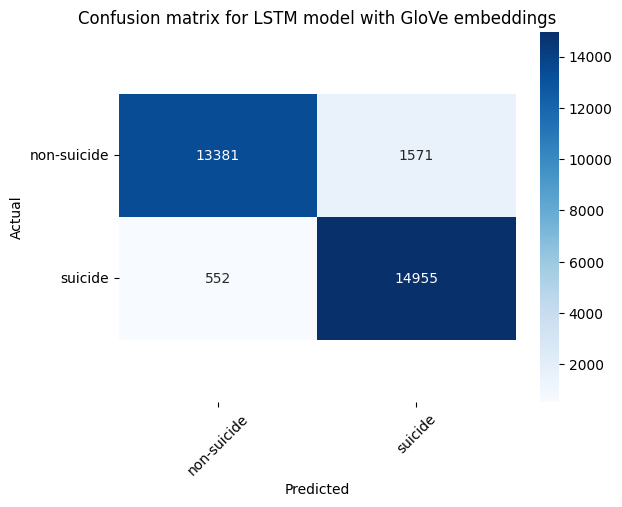

In [55]:
# Get results
analyze_lstm_model(glove_lstm_model, val_features, y_validation, "LSTM model with GloVe embeddings")

It can be seen that this is the best performing model so far, with a recall (suicide) score of 96.44 %

# 8. Transformers

## 8.1. DistilBert

In [72]:
# Converting lists of tokens to lists of strings to be used by DistilBert

def detokenizer(value):
    """
    Convert list of tokens to a string
    ['i','am','teapot'] -> 'i am teapot'
    :param value: List of tokens
    :returns: String of joined tokens
    """
    return ' '.join(value)

# Use detokenizer function
X_train_bert = list(X_train.apply(detokenizer))
X_validation_bert = list(X_validation.apply(detokenizer))

In [73]:
# Create function to transform data to be used by BERT

def create_feature_transform_bert(texts, max_length=128):
    """
    Convert text to input IDs and attention masks for DistilBERT
    :param texts: List of input text strings
    :param max_length: Maximum length of the tokenized sequences
    :returns: Function to transform text, and the tokenizer itself
    """
    # Initialize DistilBERT tokenizer
    tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

    # Tokenization function
    def transform(texts):
        """
        Tokenize input text and return padded input_ids and attention_mask
        :param texts: List of input text strings
        :return: Dictionary with 'input_ids' and 'attention_mask'
        """
        encoding = tokenizer(
            texts,
            truncation=True,          # Truncate sequences longer than max_length
            padding='max_length',     # Pad sequences to max_length
            max_length=max_length,
            return_tensors='tf'
        )
        return {
            'input_ids': encoding['input_ids'],
            'attention_mask': encoding['attention_mask']
        }
    
    return transform, tokenizer

# Parameters
MAX_LENGTH = 128

# Create a BERT feature-transforming function
to_bert_features, tokenizer = create_feature_transform_bert(X_train_bert, max_length=MAX_LENGTH)

# Convert text to BERT-compatible features
X_train_features = to_bert_features(X_train_bert)
X_val_features = to_bert_features(X_validation_bert)

# Check the output structure
print(X_train_features['input_ids'].shape)
print(X_train_features['attention_mask'].shape)

(121836, 128)
(121836, 128)


In [34]:
# Create a function that can train the DistilBert

def train_distilBert(X_train_features, X_val_features, y_target, y_validation, num_epochs=3, batch_size=128, learning_rate=3e-5):
    """
    Train a DistilBERT model for binary classification.
    :param X_train_features: Tokenized input features (input_ids and attention_mask)
    :param X_val_features
    :param y_target: Training labels
    :param y_validation: Validation labels
    :param num_epochs: Number of training epochs
    :param batch_size: Batch size
    :param learning_rate: Learning rate for the optimizer
    :returns: Trained DistilBERT model
    """
    # Load the DistilBERT configuration and model
    config = DistilBertConfig.from_pretrained('distilbert-base-uncased', num_labels=2)
    distilBert_model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', config=config)

    # Convert the features to TensorFlow datasets
    train_dataset = tf.data.Dataset.from_tensor_slices((dict(X_train_features), y_target)).batch(batch_size)
    val_dataset = tf.data.Dataset.from_tensor_slices((dict(X_val_features), y_validation_np)).batch(batch_size)

    # Define optimizer and loss function
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

    # Custom training step
    @tf.function
    def train_step(input_ids, attention_mask, labels):
        with tf.GradientTape() as tape:
            logits = distilBert_model(input_ids, attention_mask=attention_mask, training=True).logits
            loss = loss_fn(labels, logits)
        grads = tape.gradient(loss, distilBert_model.trainable_variables)
        optimizer.apply_gradients(zip(grads, distilBert_model.trainable_variables))
        return loss

    # Training loop
    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        for step, (batch_inputs, batch_labels) in tqdm(enumerate(train_dataset), total=len(train_dataset)):
            loss = train_step(batch_inputs['input_ids'], batch_inputs['attention_mask'], batch_labels)
            if step % 100 == 0:
                print(f"Step {step}, Loss: {loss.numpy()}")

    return distilBert_model

In [ ]:
# Train the model

distilBert_batchsize = 128

# Only 1 epoch, due to constraints on time and computational resources
distilBert_model = train_distilBert(X_train_features, X_val_features, y_train_np, y_validation_np, 
                                    num_epochs=1, batch_size=distilBert_batchsize)

# Save the model 
distilBert_model.save_pretrained('distilBert_model1')

# Save the tokenizer 
tokenizer.save_pretrained('distilBert_tokenizer1')

In [74]:
# Load the saved  model
distilBert_model = TFDistilBertForSequenceClassification.from_pretrained('distilBert_model')

# Load the tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilBert_tokenizer')

Some layers from the model checkpoint at distilBert_model were not used when initializing TFDistilBertForSequenceClassification: ['dropout_139']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilBert_model and are newly initialized: ['dropout_39']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [75]:
# A copy of the analyze function has been modified so it suits DistilBert output

def analyze_bert_model(model, X_val, y_val, model_name="DistilBert"):
    """
    Analyze BERT model based on validation data
    
    :param model: BERT model
    :param X_val: validation dataset
    :param y_val: validation target
    :param model_name: name of the model
    :return: None
    """
    val_dataset = X_val
    classes=["non-suicide", "suicide"]
    y_pred = []

    for batch_inputs, _ in val_dataset:
        logits = model(batch_inputs['input_ids'], attention_mask=batch_inputs['attention_mask'], training=False).logits
        predictions = tf.argmax(logits, axis=-1).numpy()
        y_pred.extend(predictions)

    y_pred = [classes[p] for p in y_pred]
    cm = confusion_matrix(y_val, y_pred)
    cost_of_model = np.multiply(cm, COST_MATRIX).sum()

    print("================" * 4)
    print(f"{model_name} metrics")
    print("================" * 4)
    print(f"accuracy score          = {round(accuracy_score(y_val, y_pred) * 100, 3)}%")
    print(f"cost of model           = {cost_of_model}")
    print(f"F1 score  - suicide     = {round(f1_score(y_val, y_pred, pos_label='suicide') * 100, 3)}%")
    print(f"F1 score  - non-suicide = {round(f1_score(y_val, y_pred, pos_label='non-suicide') * 100, 3)}%")
    print(f"recall    - suicide     = {round(recall_score(y_val, y_pred, pos_label='suicide') * 100, 3)}%")
    print(f"recall    - non-suicide = {round(recall_score(y_val, y_pred, pos_label='non-suicide') * 100, 3)}%")
    print(f"precision - suicide     = {round(precision_score(y_val, y_pred, pos_label='suicide') * 100, 3)}%")
    print(f"precision - non-suicide = {round(precision_score(y_val, y_pred, pos_label='non-suicide') * 100, 3)}%")
    print("================" * 4)
    
    title = f'Confusion matrix for {model_name}'
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=classes, yticklabels=classes)
    
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    
    bottom, top = plt.ylim()
    plt.ylim(bottom + 0.5, top - 0.5)
    plt.xticks(rotation=45)
    plt.yticks

In [76]:
distilBert_batchsize = 128

2024-12-20 00:26:44.699237: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


DistilBert metrics
accuracy score          = 94.054%
cost of model           = 6779
F1 score  - suicide     = 94.291%
F1 score  - non-suicide = 93.797%
recall    - suicide     = 96.44%
recall    - non-suicide = 91.58%
precision - suicide     = 92.235%
precision - non-suicide = 96.125%


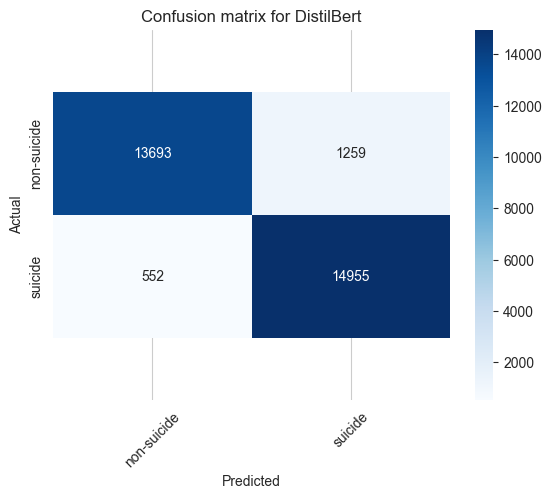

In [80]:
# Get model results

# First convert validation dataset into TensorFlow dataset
val_dataset_tf = tf.data.Dataset.from_tensor_slices((dict(X_val_features), y_validation_np)).batch(distilBert_batchsize)

# Evaluate model
analyze_bert_model(distilBert_model, val_dataset_tf, y_validation)

This attempt has produced the overall best model with the least cost.

The result could potentially be improved by experimenting with model hyperparameters.

# 9. Evaluate on unseen data

Evaluating the best model to see which one performs best on unseen data.

## 9.1. Baseline model (MNB) evaluation

Baseline model - Multinomial Naive Bayes metrics
accuracy score          = 89.739 %
cost of model           = 26390
F1 score  - suicide     = 90.344 %
F1 score  - non-suicide = 89.053 %
recall    - suicide     = 94.547 %
recall    - non-suicide = 84.78 %
precision - suicide     = 86.5 %
precision - non-suicide = 93.778 %


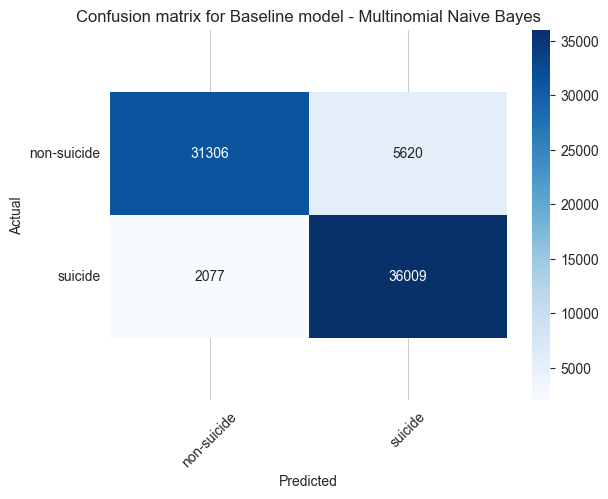

In [58]:
# Unseen data for evaluation
X_unseen_mnb = vectorizer.transform(X_unseen_data)
y_unseen_mnb = y_unseen_data

# Evaluate on unseen data
analyze_model(mnb_model, X_unseen_mnb, y_unseen_mnb, "Baseline model evaluation - Multinomial Naive Bayes")

## 9.2. LSTM + GloVe embeddings evaluation

2345/2345 ━━━━━━━━━━━━━━━━━━━━ 38s 16ms/step
LSTM model with GloVe embeddings evaluation metrics
accuracy score          = 92.968 %
cost of model           = 17821
F1 score  - suicide     = 93.294 %
F1 score  - non-suicide = 92.608 %
recall    - suicide     = 96.34 %
recall    - non-suicide = 89.49 %
precision - suicide     = 90.435 %
precision - non-suicide = 95.952 %


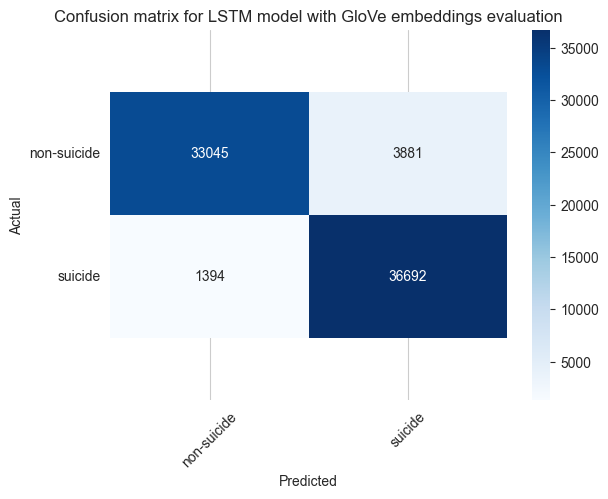

In [68]:
# Unseen data for evaluation
X_unseen_glove = to_glove_features(X_unseen_data)
y_unseen_glove = y_unseen_data

# Get results
analyze_lstm_model(glove_lstm_model, X_unseen_glove, y_unseen_glove, "LSTM model with GloVe embeddings evaluation")

## 9.3. Transformers: DistilBert evaluation

In [78]:
# Prepare unseen data for evaluation

X_unseen_bert = list(X_unseen_data.apply(detokenizer)) # Use detokenizer function
X_unseen_features = to_bert_features(X_unseen_bert) # Convert text to BERT-compatible features

y_unseen_numeric = y_unseen_data.apply(lambda x: {'suicide': 1, 'non-suicide': 0}[x])
y_unseen_np = np.array(y_unseen_numeric, dtype=np.float32)

# Convert unseen features into TensorFlow dataset
unseen_dataset_tf = tf.data.Dataset.from_tensor_slices((dict(X_unseen_features), y_unseen_np)).batch(distilBert_batchsize)

2024-12-20 14:55:16.692813: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


DistilBert metrics
accuracy score          = 94.05%
cost of model           = 16937
F1 score  - suicide     = 94.268%
F1 score  - non-suicide = 93.815%
recall    - suicide     = 96.361%
recall    - non-suicide = 91.667%
precision - suicide     = 92.264%
precision - non-suicide = 96.066%


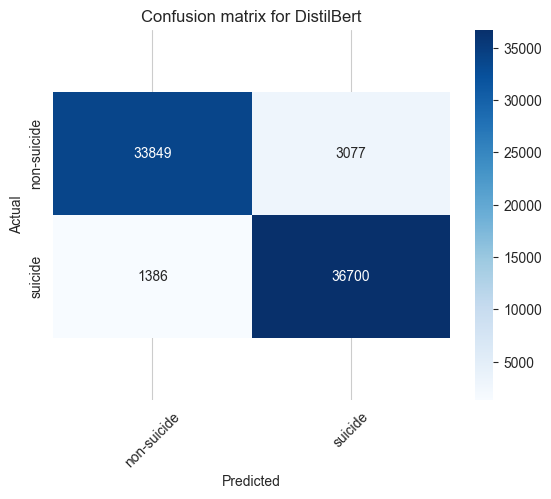

In [79]:
# Evaluate model

analyze_bert_model(distilBert_model, unseen_dataset_tf, y_unseen_data)

The DistilBert model has the least cost and the overall best performance on unseen data.